In [4]:
import json, os, pickle, random
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn

import qiskit
from qiskit import QuantumCircuit, execute
from qiskit.compiler import transpile
from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.quantum_info import SparsePauliOp, Operator
from qiskit.circuit.library import CXGate, RXGate, IGate, ZGate
from qiskit.providers.fake_provider import FakeMontreal, FakeLima

from utils import get_backend_properties_v1
from mlp import MLP1, MLP2, MLP3, encode_data

import matplotlib.pyplot as plt
import seaborn as sns
from noise_utils import AddNoise, RemoveReadoutErrors
from mlp import recursive_dict_loop, count_gates_by_rotation_angle
from mbd_utils import calc_imbalance
import torch
from torch import nn
from sklearn import datasets
import sklearn
from utils import circuit_to_graph_data_json
from utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
)
from qiskit.circuit.random import random_circuit
from sklearn.model_selection import train_test_split
import gate_dict
from qiskit.converters import circuit_to_dag
#from utils import encode_data

In [5]:
backend = FakeLima()
gate_dict = gate_dict.gate_dict()

In [6]:
backend_properties = get_backend_properties_v1(backend)

In [7]:
backend_properties

{'name': 'fake_lima',
 'gates_set': ['id', 'sx', 'cx', 'rz', 'reset', 'x'],
 'num_qubits': 5,
 'qubits_props': {0: {'index': 0,
   't1': 5.9698643286635694e-05,
   't2': 9.355584184359312e-05,
   'readout_error': 0.026100000000000012},
  1: {'index': 1,
   't1': 8.305997230317399e-05,
   't2': 0.00011553074510239035,
   'readout_error': 0.020000000000000018},
  2: {'index': 2,
   't1': 0.00010377694598809795,
   't2': 9.477169960638749e-05,
   'readout_error': 0.016599999999999948},
  3: {'index': 3,
   't1': 4.358447375590962e-05,
   't2': 4.645933441447346e-05,
   'readout_error': 0.0515000000000001},
  4: {'index': 4,
   't1': 1.7543975812787366e-05,
   't2': 1.6441110002077736e-05,
   'readout_error': 0.057499999999999996}},
 'gate_props': {'id_0': {'index': 'id_0',
   'gate_error': 0.00019195510390342677,
   'gate_length': 35.55555555555556},
  'id_1': {'index': 'id_1',
   'gate_error': 0.00033064681663890665,
   'gate_length': 35.55555555555556},
  'id_2': {'index': 'id_2',
   'g

In [8]:
def create_train_and_test_data(n_qubits: int, 
                               circuit_depth: int, 
                               pauli_terms: int, 
                               pauli_coeff: float = 1.0, 
                               max_entries: int = 10, 
                               properties = get_backend_properties_v1(backend)):
    
    circuits_list = []
    ideal_exp_vals_list = []
    noisy_exp_vals_list = []

    for _ in range(max_entries):
        circ_qubits = random.randint(1, n_qubits)
        #circ_qubits = n_qubits
        qc = random_circuit(circ_qubits, random.randint(1, circuit_depth))

        observable = generate_random_pauli_sum_op(circ_qubits, pauli_terms, pauli_coeff)

        ideal_exp_val, noisy_exp_val = create_estimator_meas_data(
            backend=backend, circuit=qc, observable=observable
        )

        circuits_list.append(qc)
        ideal_exp_vals_list.append(ideal_exp_val)
        noisy_exp_vals_list.append(noisy_exp_val)

    return circuits_list, ideal_exp_vals_list, noisy_exp_vals_list


In [9]:
# circ specified 
n_qubits = 4
circ_depth = 20
pauli_terms = 8

In [10]:
train_circuits, train_ideal_exp_vals, train_noisy_exp_vals = create_train_and_test_data(n_qubits=n_qubits,
                                                                                        circuit_depth=circ_depth,
                                                                                        pauli_terms=pauli_terms,
                                                                                        max_entries=5)

test_circuits, test_ideal_exp_vals, test_noisy_exp_vals = create_train_and_test_data(n_qubits=n_qubits,
                                                                                    circuit_depth=circ_depth,
                                                                                    pauli_terms=pauli_terms,
                                                                                    max_entries=1)

In [27]:

import pickle

def save_data(train_circuits, train_ideal_exp_vals, train_noisy_exp_vals, test_circuits, test_ideal_exp_vals, test_noisy_exp_vals, file_name):
    data = {
        "train_circuits": train_circuits,
        "train_ideal_exp_vals": train_ideal_exp_vals,
        "train_noisy_exp_vals": train_noisy_exp_vals,
        "test_circuits": test_circuits,
        "test_ideal_exp_vals": test_ideal_exp_vals,
        "test_noisy_exp_vals": test_noisy_exp_vals
    }
    with open(file_name, 'wb') as f:
        pickle.dump(data, f)

In [28]:
file_name = 'random_circ_4_20_8_5_1'

In [30]:
save_data(train_circuits, train_ideal_exp_vals, train_noisy_exp_vals, test_circuits, test_ideal_exp_vals, test_noisy_exp_vals, file_name)

In [19]:
type(train_circuits[1])

qiskit.circuit.quantumcircuit.QuantumCircuit

In [20]:
train_ideal_exp_vals

[-1.05078125, 0.23046875, 1.529296875, -1.37890625, -0.10546875]

In [23]:
train_noisy_exp_vals[0]

-1.126953125

In [8]:
def get_qc_operations(qc):
    qc = transpile(circuits=qc, 
               backend=backend, 
               optimization_level=0)
    operations = []
    for operation in qc.data:
        operations.append(operation)
    return operations

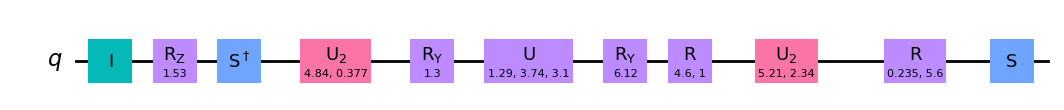

In [9]:
train_circuits[100].draw('mpl')

In [10]:
# each word is -> gatetype, params, t1, t2, readout_error, gate_error, gate_length

def operations_to_features(circuits, true_exp_vals, n_qubits):
    X = []
    i = 0
    for qc in circuits:
        #dag_circuit = circuit_to_dag(qc)
        circuit_instructions = get_qc_operations(qc)
        # CircuitInstruction(operation=Instruction(name='rz', num_qu .... :)))))))
        features = []
        for i in range(n_qubits):
            features.append([])
        # qubit errors 
        for qubit_index in range(n_qubits):
            t1 = backend_properties['qubits_props'][qubit_index]['t1']
            t2 = backend_properties['qubits_props'][qubit_index]['t2']
            readout_error = backend_properties['qubits_props'][qubit_index]['readout_error']
            features[qubit_index].append([0, 0, t1, t2, readout_error, 0, 0])
        for circuit_instruction in circuit_instructions:
            gate_instruction = circuit_instruction.operation # the quantum gate applied to a qubit/qubits
            op_name = gate_instruction.name
            #print(op_name)
            op_params = gate_instruction.params

            if len(op_params) == 0:
                op_params = float('0')
            else:
                op_params = op_params[0]

            op_encoded = gate_dict[op_name]
            op_qubit = circuit_instruction.qubits
            op_qubit_index = op_qubit[0].index

            if op_name == 'cx':
                op_gate_quibts = circuit_instruction.qubits
                backend_op_name = f'{op_name}_{op_gate_quibts[0].index}_{op_gate_quibts[1].index}'
            else:
                backend_op_name = f'{op_name}_{op_qubit_index}'

            gate_error = backend_properties['gate_props'][backend_op_name]['gate_error']
            gate_length = backend_properties['gate_props'][backend_op_name]['gate_length']
            'sx_1'

            qubit_feature = [op_encoded, op_params, 0, 0, 0, gate_error, gate_length]
            features[op_qubit_index].append(qubit_feature)
            #print(f'{op_encoded} | {op_params} | {op_qubit}')

        max_length = max(len(sublist) for sublist in features)
        for sublist in features:
            while len(sublist) < max_length:
                sublist.append([float('0'), float('0'), float('0'), float('0'), float('0'), float('0'), float('0')])

        X.append(features)

    y = []
    for exp_val in true_exp_vals:
        y.append(exp_val)
        
    return X, y

In [11]:
X_train, y_train = operations_to_features(train_circuits, train_ideal_exp_vals, n_qubits)
X_test, y_test = operations_to_features(test_circuits, test_ideal_exp_vals, n_qubits)

In [12]:
X_train[0]

[[[0,
   0,
   5.9698643286635694e-05,
   9.355584184359312e-05,
   0.026100000000000012,
   0,
   0],
  [14, 5.26421100910275, 0, 0, 0, 0, 0],
  [14, -1.5707963267948966, 0, 0, 0, 0, 0],
  [14, 2.280804858631058, 0, 0, 0, 0, 0],
  [14, -1.5707963267948966, 0, 0, 0, 0, 0],
  [14, 3.141592653589793, 0, 0, 0, 0, 0],
  [14, 1.5707963267948966, 0, 0, 0, 0, 0],
  [16, 0.0, 0, 0, 0, 0.00019195510390342677, 35.55555555555556],
  [14, 6.283185307179586, 0, 0, 0, 0, 0],
  [16, 0.0, 0, 0, 0, 0.00019195510390342677, 35.55555555555556],
  [14, 10.995574287564276, 0, 0, 0, 0, 0],
  [14, 1.614031204636174, 0, 0, 0, 0, 0],
  [14, 0.0, 0, 0, 0, 0, 0],
  [16, 0.0, 0, 0, 0, 0.00019195510390342677, 35.55555555555556],
  [14, 4.42673880199339, 0, 0, 0, 0, 0],
  [16, 0.0, 0, 0, 0, 0.00019195510390342677, 35.55555555555556],
  [14, 9.42477796076938, 0, 0, 0, 0, 0],
  [14, 1.5707963267948966, 0, 0, 0, 0, 0],
  [14, 3.200416524799479, 0, 0, 0, 0, 0],
  [4, 0.0, 0, 0, 0, 0.00019195510390342677, 35.555555555555

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim

In [14]:
import numpy as np

def evaluate_model(rnn_extractor, predictor, criterion, X, y):
    with torch.no_grad():
        all_predictions = []
        all_losses = []
        for i in range(len(X)):
            circ_features_tensor = torch.FloatTensor(X[i])
            rnn_output = rnn_extractor(circ_features_tensor)
            rnn_output = torch.flatten(rnn_output)
            noisy_exp_val = torch.from_numpy(np.array(np.float32(test_noisy_exp_vals[i])))
            rnn_output_noisy_exp_val = torch.cat((rnn_output, noisy_exp_val.reshape(1)))
            pred = predictor(rnn_output_noisy_exp_val)
            loss = criterion(pred, torch.FloatTensor([y[i]]))
            
            all_predictions.append(pred.item())
            all_losses.append(loss.item())
        
        rmse = np.sqrt(np.mean(np.square(np.array(all_predictions) - np.array(y))))

        #print(rnn_extractor.parameters())
        
        return rmse



In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# remake this because its not working as intented i think, play with dropout as it does a lot

class RNNFeatureExtractor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNNFeatureExtractor, self).__init__()
        self.qubit_rnns = nn.ModuleDict()
        for i in range(n_qubits):
            self.qubit_rnns[f'rnn_{i}'] = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=0.1)

        
    def forward(self, x):
        rnn_outputs = []
        #print(x.shape)
        for rnn in self.qubit_rnns.values():
            rnn_output, _ = rnn(x)
            rnn_output_last = rnn_output[:, -1, :]
            rnn_outputs.append(rnn_output_last)     
        
        output = torch.stack(rnn_outputs, dim=1)
        #print(output.shape)
        #print(1 + '3')
        return output


class ExpectationValuePredictor(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               hidden_layers: int,
               output_shape: int,
               p_drouput: int):
    super().__init__()
    self.layers = nn.ModuleDict()
    self.nLayers = hidden_layers

    self.layers['input'] = nn.Linear(input_shape * n_qubits + 1,
                                     hidden_units)

    for i in range(hidden_layers):
      self.layers[f'hidden{i}'] = nn.Linear(hidden_units,
                                            hidden_units)

    self.layers['output'] = nn.Linear(hidden_units,
                                      output_shape)
    
    self.dropout = p_drouput

  def forward(self, x):
    #print(x.shape)
    x = torch.flatten(x)
    ReLU = nn.ReLU()

    x = ReLU(self.layers['input'](x))

    #print(x.shape)

    for i in range(self.nLayers):
        x = ReLU(self.layers[f'hidden{i}'](x))
        x = torch.nn.functional.dropout(x, p=self.dropout, training=self.training)

    x = self.layers['output'](x)

    return x

def train_and_evaluate_model(rnn_extractor, predictor, criterion, optimizer, X_train, y_train, X_test, y_test, num_epochs):
    for epoch in range(num_epochs):
        rnn_extractor.train()
        predictor.train()
        train_losses = []
        for i in range(len(X_train)):
            circ_features_tensor = torch.FloatTensor(X_train[i])
            rnn_output = rnn_extractor(circ_features_tensor)
            rnn_output = torch.flatten(rnn_output)
            noisy_exp_val = torch.from_numpy(np.array(np.float32(train_noisy_exp_vals[i])))
            rnn_output_noisy_exp_val = torch.cat((rnn_output, noisy_exp_val.reshape(1)))
            #print(rnn_output_noisy_exp_val)
            #print(type(rnn_output_noisy_exp_val))
            pred = predictor(rnn_output_noisy_exp_val)
            loss = criterion(pred, torch.FloatTensor([y_train[i]]))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        
        rnn_extractor.eval()
        predictor.eval()
        test_mse = evaluate_model(rnn_extractor, predictor, criterion, X_test, y_test)

        if epoch % 1 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}, "
                f"Train Loss: {train_loss:.4f}, "
                f"Test RMSE: {test_mse:.4f}")
            
        #print(rnn_extractor.state_dict())

input_size = 7
hidden_size = 8
num_layers = 4
output_size = 1

rnn_extractor = RNNFeatureExtractor(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
predictor = ExpectationValuePredictor(input_shape=(hidden_size * n_qubits), hidden_units=64, hidden_layers=2, output_shape=output_size, p_drouput=0.1)

criterion = nn.MSELoss()
optimizer = optim.Adam(list(predictor.parameters()) + list(rnn_extractor.parameters()), lr=0.001)

num_epochs = 5
train_and_evaluate_model(rnn_extractor, predictor, criterion, optimizer, X_train, y_train, X_test, y_test, num_epochs)


Epoch 1/5, Train Loss: 0.4058, Test RMSE: 0.4683
Epoch 2/5, Train Loss: 0.1508, Test RMSE: 0.3324
Epoch 3/5, Train Loss: 0.1289, Test RMSE: 0.3152
Epoch 4/5, Train Loss: 0.1319, Test RMSE: 0.2413
Epoch 5/5, Train Loss: 0.1223, Test RMSE: 0.2844


In [16]:
num_epochs = 8
optimizer = optim.Adam(list(predictor.parameters()) + list(rnn_extractor.parameters()), lr=0.0001)
train_and_evaluate_model(rnn_extractor, predictor, criterion, optimizer, X_train, y_train, X_test, y_test, num_epochs)

Epoch 1/8, Train Loss: 0.0949, Test RMSE: 0.2341
Epoch 2/8, Train Loss: 0.0953, Test RMSE: 0.2360
Epoch 3/8, Train Loss: 0.0986, Test RMSE: 0.2395
Epoch 4/8, Train Loss: 0.0878, Test RMSE: 0.2341
Epoch 5/8, Train Loss: 0.0923, Test RMSE: 0.2305
Epoch 6/8, Train Loss: 0.0959, Test RMSE: 0.2447
Epoch 7/8, Train Loss: 0.0913, Test RMSE: 0.2419
Epoch 8/8, Train Loss: 0.0924, Test RMSE: 0.2557


In [17]:
num_epochs = 4
optimizer = optim.Adam(list(predictor.parameters()) + list(rnn_extractor.parameters()), lr=0.00001)
train_and_evaluate_model(rnn_extractor, predictor, criterion, optimizer, X_train, y_train, X_test, y_test, num_epochs)

Epoch 1/4, Train Loss: 0.0885, Test RMSE: 0.2286
Epoch 2/4, Train Loss: 0.0850, Test RMSE: 0.2290
Epoch 3/4, Train Loss: 0.0831, Test RMSE: 0.2285
Epoch 4/4, Train Loss: 0.0862, Test RMSE: 0.2280


In [26]:
num_epochs = 4
optimizer = optim.Adam(list(predictor.parameters()) + list(rnn_extractor.parameters()), lr=0.00001)
train_and_evaluate_model(rnn_extractor, predictor, criterion, optimizer, X_train, y_train, X_test, y_test, num_epochs)

Epoch 1/4, Train Loss: 0.0878, Test RMSE: 0.2283
Epoch 2/4, Train Loss: 0.0904, Test RMSE: 0.2295
Epoch 3/4, Train Loss: 0.0865, Test RMSE: 0.2283
Epoch 4/4, Train Loss: 0.0851, Test RMSE: 0.2295


In [18]:
def fix_random_seed(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    print(f'random seed fixed to {seed}')

In [19]:
properties = get_backend_properties_v1(backend=backend)

In [28]:
X_train_rf, y_train_rf = encode_data(train_circuits, properties, train_ideal_exp_vals, train_noisy_exp_vals, num_qubits=n_qubits)
X_test_rf, y_test_rf = encode_data(test_circuits, properties, test_ideal_exp_vals, test_noisy_exp_vals, num_qubits=n_qubits)
BATCH_SIZE = 32
fix_random_seed(42)
train_dataset = TensorDataset(torch.Tensor(X_train_rf), torch.Tensor(y_train_rf))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = TensorDataset(torch.Tensor(X_test_rf), torch.Tensor(y_test_rf))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*1000, shuffle=False)

random seed fixed to 42


In [29]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
rfr = RandomForestRegressor(n_estimators=300)
rfr.fit(X_train_rf, y_train_rf)

RandomForestRegressor(n_estimators=300)

In [30]:
from sklearn.metrics import root_mean_squared_error

In [31]:
y_pred_rf = rfr.predict(X_test_rf)
rms = root_mean_squared_error(y_test_rf, y_pred_rf)

In [32]:
rms

0.2741066131812843